In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Load datasets
customers = pd.read_csv('C:\Data-Science-Assignment-eCommerce-Transactions-Dataset\Dataset\Customers .csv')
products = pd.read_csv('C:\Data-Science-Assignment-eCommerce-Transactions-Dataset\Dataset\Products.csv')
transactions = pd.read_csv('C:\Data-Science-Assignment-eCommerce-Transactions-Dataset\Dataset\Transactions.csv')

In [31]:
# Merge transactions with products to include product details
transactions_products = pd.merge(transactions, products, on='ProductID', how='left')

# Merge with customers to include customer details
data = pd.merge(transactions_products, customers, on='CustomerID', how='left')

In [32]:
# Keep Price_y as the correct Price column
data['Price'] = data['Price_y']  # Rename Price_y to Price

# Drop Price_x and Price_y to avoid confusion
data.drop(columns=['Price_x', 'Price_y'], inplace=True)

# Verify the updated DataFrame
print(data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'ProductName', 'Category', 'CustomerName',
       'Region', 'SignupDate', 'Price'],
      dtype='object')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   ProductName      1000 non-null   object 
 8   Category         1000 non-null   object 
 9   Price_y          1000 non-null   float64
 10  CustomerName     1000 non-null   object 
 11  Region           1000 non-null   object 
 12  SignupDate       1000 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


In [33]:
customer_profiles=data.columns[data.dtypes!='object']

In [34]:
customer_profiles=data

In [35]:
customer_profiles

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,ProductName,Category,CustomerName,Region,SignupDate,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,Andrea Jenkins,Europe,2022-12-03,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,Brittany Harvey,Asia,2024-09-04,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,Kathryn Stevens,Europe,2024-04-04,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,ComfortLiving Bluetooth Speaker,Electronics,Travis Campbell,South America,2024-04-11,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,ComfortLiving Bluetooth Speaker,Electronics,Timothy Perez,Europe,2022-03-15,300.68
...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 8:30:27,1,459.86,SoundWave Smartwatch,Electronics,Jacob Holt,South America,2022-01-22,459.86
996,T00759,C0059,P037,2024-06-04 2:15:24,3,1379.58,SoundWave Smartwatch,Electronics,Mrs. Kimberly Wright,North America,2024-04-07,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,SoundWave Smartwatch,Electronics,Tyler Haynes,North America,2024-09-21,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,SoundWave Smartwatch,Electronics,Joshua Hamilton,Asia,2024-11-11,459.86


In [36]:
object_columns = data.select_dtypes(include=['object']).columns

# Drop those columns from the DataFrame
df = data.drop(columns=object_columns)

In [39]:
customer_profiles = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean',      # Average price of items purchased
    'Category': lambda x: ' '.join(x.astype(str))  # Categories of products purchased
}).reset_index()

# Inspect the customer profiles
print(customer_profiles.head())

  CustomerID  TotalValue  Quantity       Price  \
0      C0001     3354.52        12  278.334000   
1      C0002     1862.74        10  208.920000   
2      C0003     2725.38        14  195.707500   
3      C0004     5354.88        23  240.636250   
4      C0005     2034.24         7  291.603333   

                                            Category  
0  Books Home Decor Electronics Electronics Elect...  
1            Home Decor Home Decor Clothing Clothing  
2         Home Decor Home Decor Clothing Electronics  
3  Books Home Decor Home Decor Home Decor Books B...  
4                 Home Decor Electronics Electronics  


In [46]:
customer_profiles.drop('CustomerID',inplace=True,axis=1)

In [48]:
clustering_data=customer_profiles

In [49]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

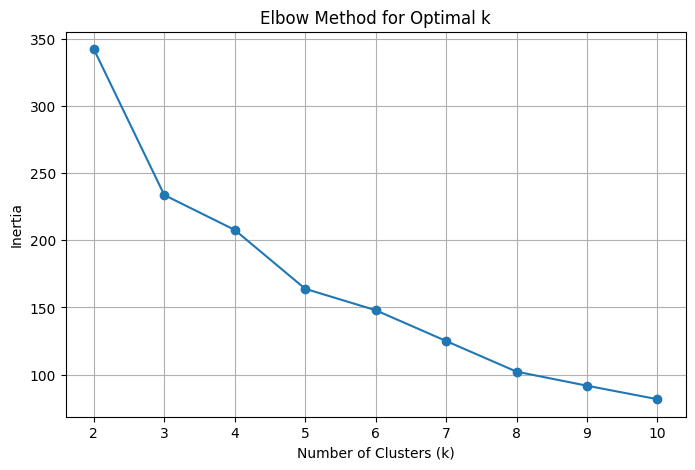

In [50]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 11)  # Test between 2 and 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [51]:
# Fit K-Means with the optimal number of clusters
optimal_k = 5 # Replace with your chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the original DataFrame
customer_profiles['Cluster'] = kmeans.labels_

In [52]:
# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.9467058109377833


In [53]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
customer_profiles['PCA1'] = reduced_data[:, 0]
customer_profiles['PCA2'] = reduced_data[:, 1]

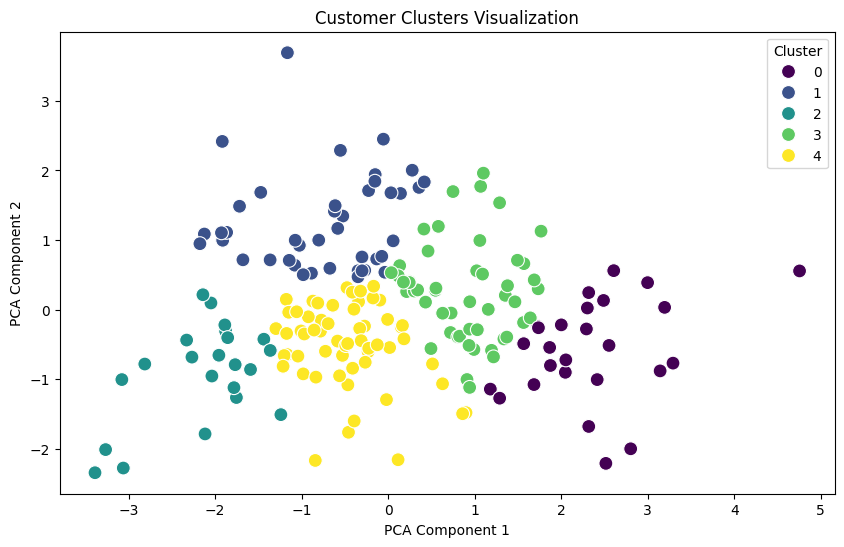

In [54]:
# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster',
    data=customer_profiles, palette='viridis', s=100
)
plt.title('Customer Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()